In [ ]:
# Import all libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob

Code organization : 
All the main functions are defined in cell #13. Includes comments in detail
The actual pipeline is laid out in cell #32.Includes comments in detail
All visualizations have been done as part of separate code cells.


# Camera calibration

The code for this step is contained in the following code cell.
I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners.
Assumption is that the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image. Thus, objp is just a replicated array of coordinates, and objpoints will be appended with a copy of it every time I successfully detect all chessboard corners in a test image. imgpoints will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.

In cell# 26, I then used the output objpoints and imgpoints to compute the camera calibration and distortion coefficients using the cv2.calibrateCamera() function. I applied distortion correction to the test image using the cv2.undistort() function.

In [12]:
# Read in all test images from the camera_cal directory. Each image is a view of a chessboard pattern at various angles
#Find chessboard corners, object points and image points
nx = 9
ny = 6
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

objpoints = []
imgpoints = []
# Read all calibration images
images = glob.glob('./camera_cal/calibration*.jpg')
for image in images:
    img = mpimg.imread(image)
# Convert to grayscale before finding corners    
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
# Use the OpenCV function findChessBoardCorners() to find the x,y coordinates of each corner on a given image    
    ret, corners = cv2.findChessboardCorners(gray,(nx, ny),None)
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

# Image filtering

I used a combination of color and gradient thresholds to generate a binary image
The functions for doing color and gradient thresholding are defined in cell# 13.
The binary image is created by combining sobel filter, S and V channel thresholding as defined under binary(image) function in cell# 13.
The output of a binary image result is provided as output of cell# 30 where the code for plotting is provided.

1) Color Masks: Apply color masks to identify yellow and white pixels in the image. HLS and HSV space is more suited for identifying colors as it segements the colors into the color themselves (Hue), the ammount of color (Saturation) and brightness (Value).
2) Sobel Filters: In addition to the color masks, we apply sobel filters to detect edges. 
3) Combine sobel filters and color masks: In a final step we combined candidate lane pixels to identify potential lane regions.


In [13]:
# Define all functions here
#Convert RGB input image to Grayscale
def graycvt(image):
    return cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)


#Define Region of Interest. Referenced from lecture Code
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255   
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image
    
# Convert to grayscale, calibrate camera and Undistort Image
# Once we have an array of all the corners, use the OpenCV calibrateCamera() function to calculate the camera matrix,
# the vector of distortion coefficients, and the camera vectors of rotation and translation.
# After camera calibration, we can  apply the camera matrix and distortion coefficients to correct distortion 
# effects on camera input images
def undistort(image, objpoints, imgpoints):
    gray = graycvt(image)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints,gray.shape[::-1],None,None)
    undist = cv2.undistort(image,mtx,dist,None,mtx)
    return undist

#Apply sobel filter and apply thresholds
#Take the input RGB image and convert to grayscale. 
#Apply Sobel filter in the X direction to get image edges that match the direction of the lane lines. 
#Sobel in y direction is not used as that works well for horizontal lines rather than vertical lines.
#Apply a threshold function on this to filter out out pixels that are not of interest. Through experiments, I found that min/max threshold 
#values of 30 and 100 seem to work well. I use this output to generate a binary image of pixels of interest.

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    gray = graycvt(img)
    if orient == 'x':
        sobel = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0])&(scaled_sobel <= thresh[1])] = 1
    return grad_binary


#1 Convert to HLS color space and get S channel since S channel is found to be the most rubust to shadows and brightness
#2) Apply a threshold to the S channel
#3) Return a binary image of threshold result
def hls_select(image,thresh =(0,255)):
    hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    binary_output = np.zeros_like(s)
    binary_output[(s > thresh[0])&(s<=thresh[1])] = 1
    return binary_output

# Convert to HSV color space and get V channel. I initially started off by experimentating with L and S channel
# from HLS and S channel, but it was not giving great results. After much experimentation, I arrived at the
# conclusion that S and V channel combination worked well together.
#2) Apply a threshold to the S channel
#3) Return a binary image of threshold result
def hsv_select(image,thresh=(0,255)):
    hsv = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    v = hsv[:,:,2]
    binary_output = np.zeros_like(v)
    binary_output[(v > thresh[0]) & (v<=thresh[1])] = 1
    return binary_output

#Combination of sobel and S,V channel space thresholding
def binary(image):
    undist = undistort(image, objpoints, imgpoints)
# Sobel thresholding - value of 30,100 seemed to work best
    gradx = abs_sobel_thresh(undist, orient='x', sobel_kernel=9, thresh=(30,100))
# Color thresholding for S channel - value of 120,255 seemed to work best
    s_channel = hls_select(undist, thresh=(120,255))
# Color thresholding for V channel - value of 75,255 seemed to work best
    v_channel = hsv_select(undist, thresh=(75,255))
    combined_binary = np.zeros_like(gradx)
# Combine sobel and S,V color thresholding to create the binary image  
    combined_binary[(gradx==1)|(s_channel==1) & (v_channel ==1)]=1
    imshape = combined_binary.shape

# Apply region masking to focus at only lane lines
    vertices = np.array([[(100,imshape[0]),(620,420),(750,450),(1200,imshape[0])]],dtype=np.int32)
    
# Apply region on the the previously generated binary image
    binary_output = region_of_interest(combined_binary,vertices)
    return undist, combined_binary, binary_output

#Perspective Transform
#Apply perspective transform. Perspective transformation gives us bird's eye view of the road, this makes further 
# processing easier as any irrelevant information about background is removed from the warped image.
def perspectiveTransform(image,src,dst):
    M = cv2.getPerspectiveTransform(src,dst)
# Warp an image using the perspective transform, M    
    transform_img = cv2.warpPerspective(image,M,(1280,720))
    return transform_img

#Measure curvature radius
#Used the computed polyline along with the estimated lane width (~3.7m) to compute the real-world lane curvature.
#Measured the position of the car with respect to the lane by computing the difference between the center of the lane
#and the center of the image.
def measureCurvature(ploty,leftx,lefty,rightx,righty):
    ym_per_pix = 30/720  # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    ymax = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_poly = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_poly = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix,2)
    
    # Calculate the new radii of curvature
    left_cur = ((1+(2*left_poly[0]*ymax*ym_per_pix + 
                          left_poly[1])**2)**1.5)/np.absolute(2*left_poly[0])
    right_cur = ((1+(2*right_poly[0]*ymax*ym_per_pix + 
                          right_poly[1])**2)**1.5)/np.absolute(2*right_poly[0])
    
    #Now our radius of curvature is in meters
    radius = (left_cur+right_cur)/2
    return radius

#Measure offset from car center to lane center
def offcenter(image,ploty,left_fit,right_fit):
    ymax = np.max(ploty)
    x_per_pix = 3.7/700
    leftx_bottom = left_fit[0]*ymax**2 + left_fit[1]*ymax + left_fit[2]
    rightx_bottom = right_fit[0]*ymax**2 + right_fit[1]*ymax + right_fit[2]
    center_lanes = (leftx_bottom + rightx_bottom)/2
    center_car = image.shape[1]/2
    off_center = (center_lanes-center_car)*x_per_pix
    return off_center

# Perspective transform

The code for my perspective transform includes a function called perspectiveTransform() defined in cell# 13.
The function takes as inputs an image (img), as well as source (src) and destination (dst) points. More details are provided in the function definition.

The transformed image is provided as output of cell# 31

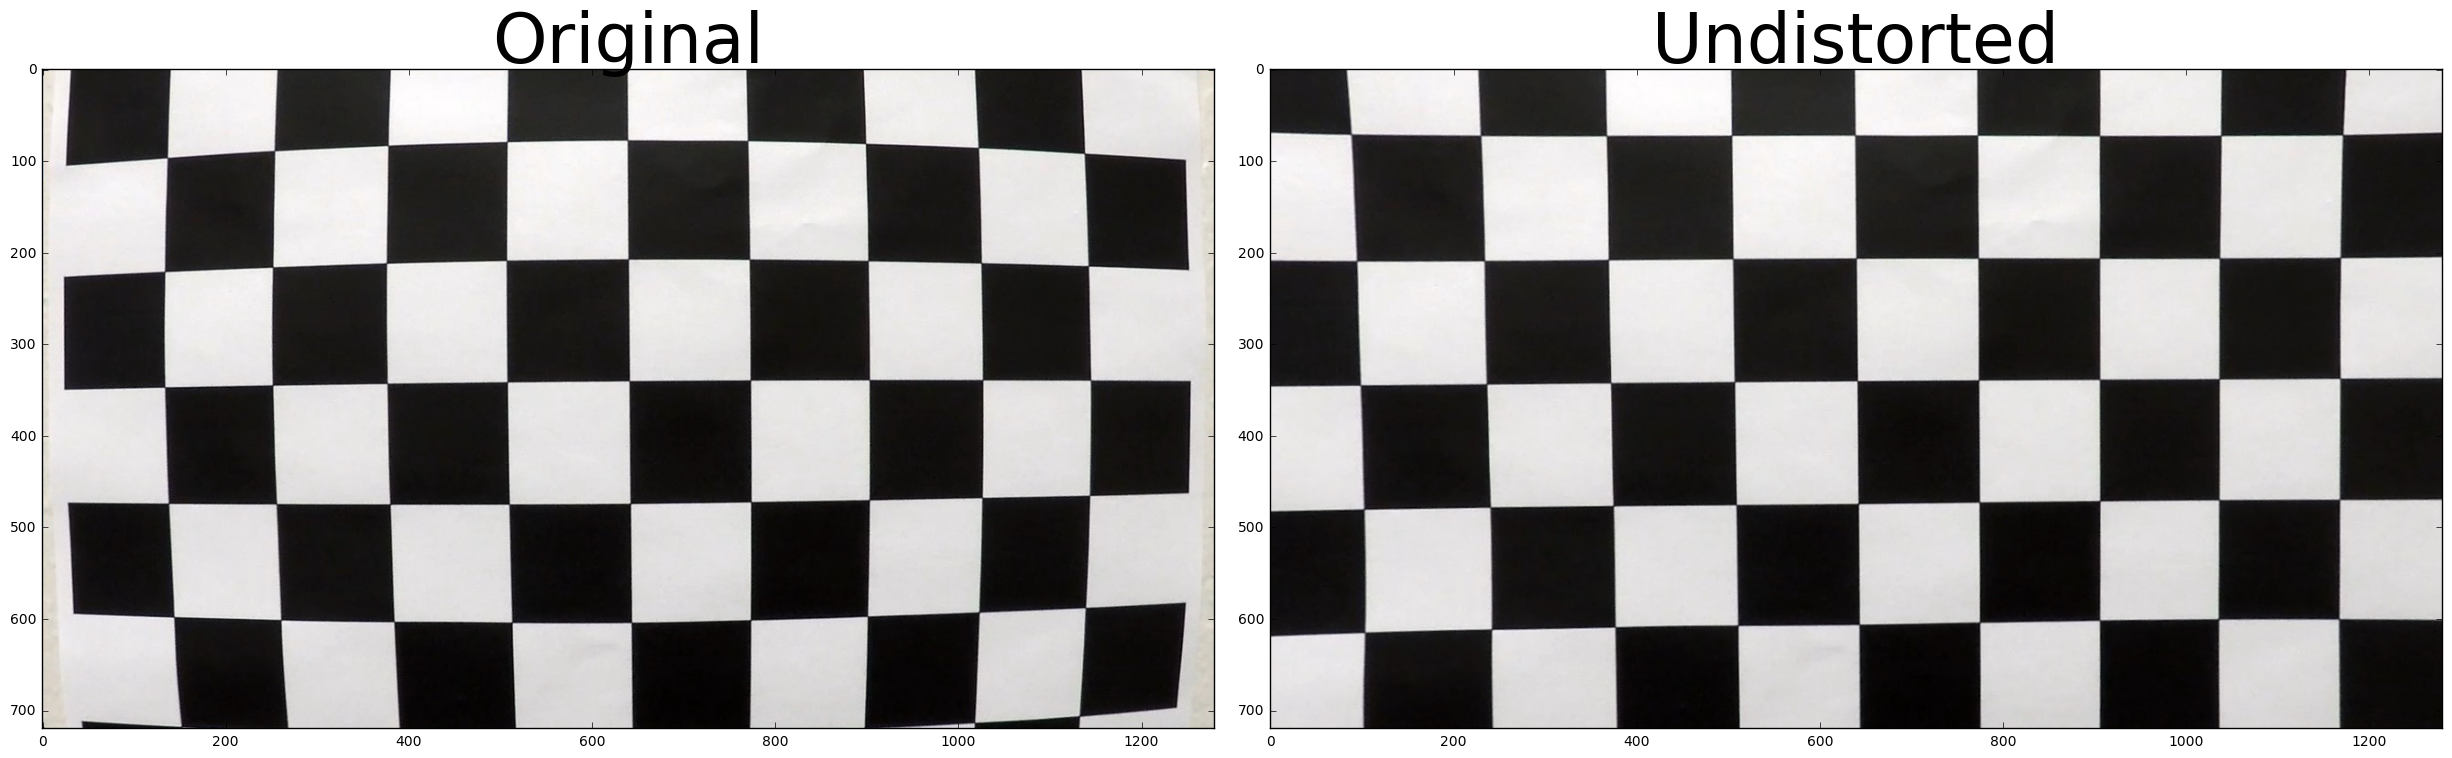

In [26]:
# Plot an original and an undistorted image of a chessboard
%matplotlib inline
ca1 = mpimg.imread('./camera_cal/calibration1.jpg')
# Calibrate the camera and undistort the image
undistort_ca1 = undistort(ca1, objpoints, imgpoints)
f, (ax1,ax2) = plt.subplots(1,2,figsize=(24,9))
f.tight_layout()
ax1.imshow(ca1) # original image
ax1.set_title('Original',fontsize=50)
ax2.imshow(undistort_ca1) # undistorted image
ax2.set_title('Undistorted',fontsize=50) 
plt.subplots_adjust(left=0.,right=1,top=0.9,bottom=0.)

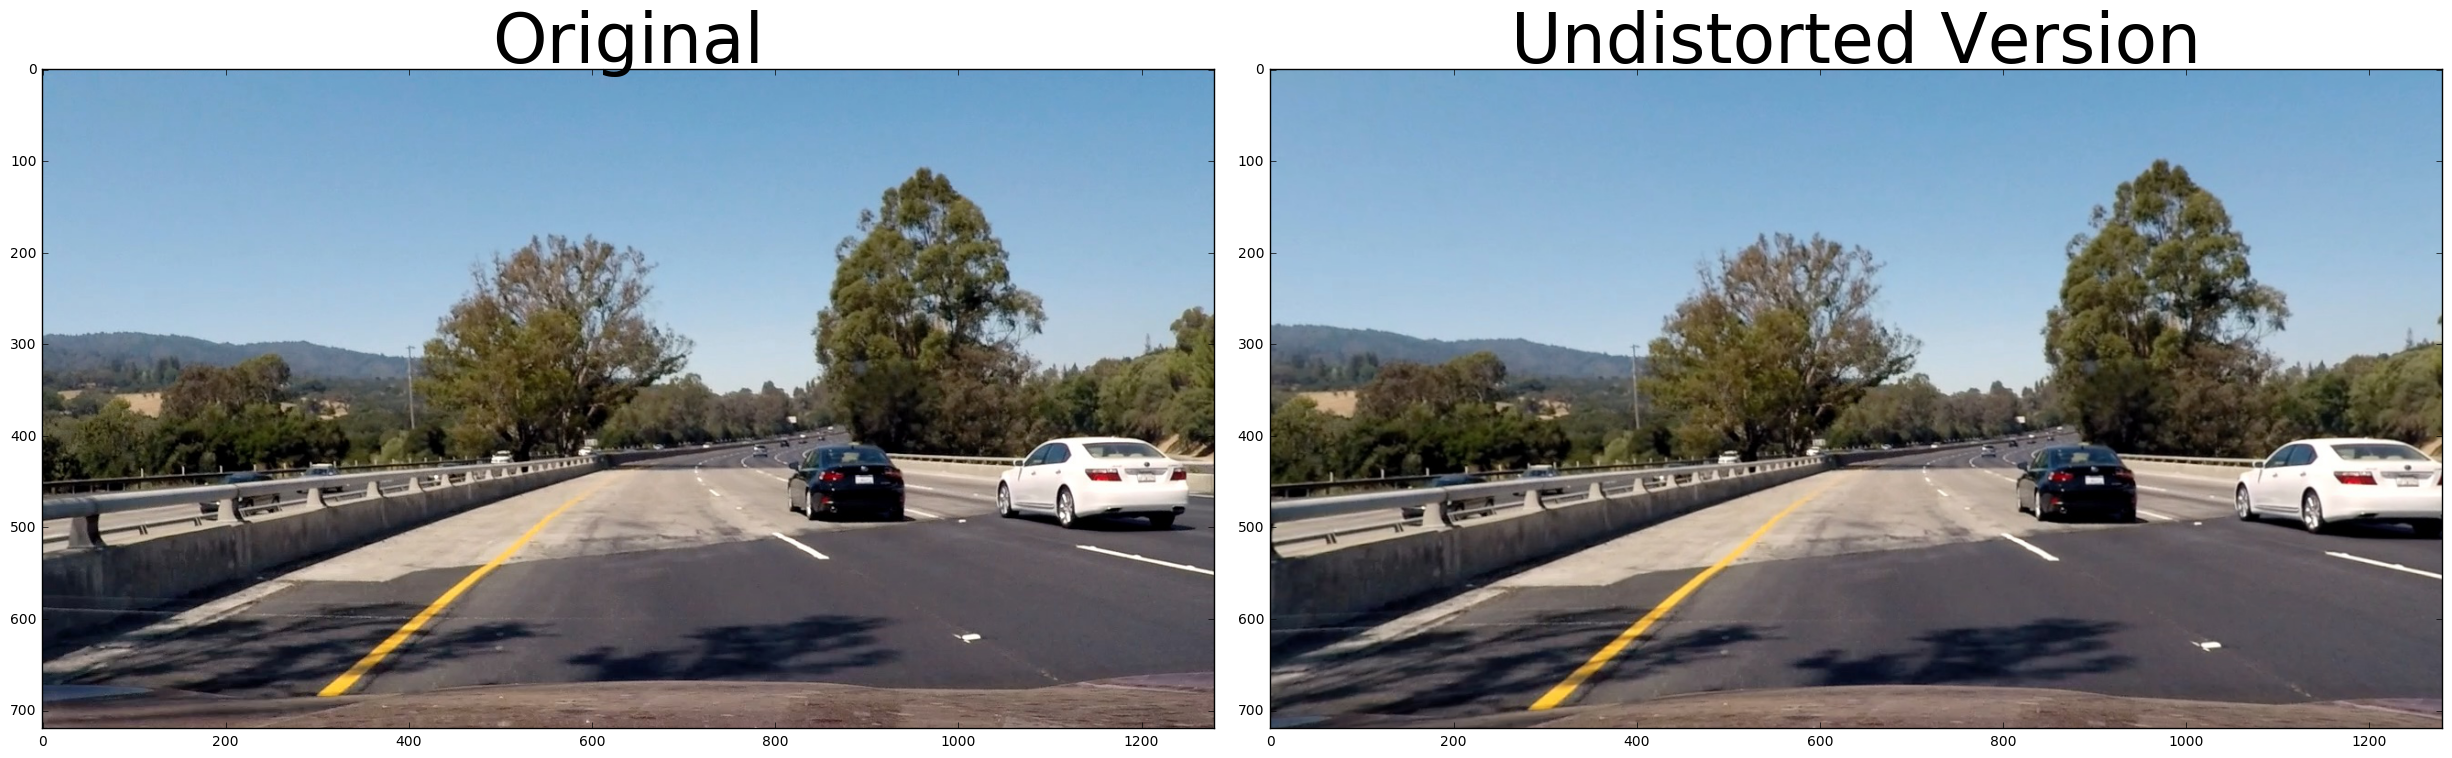

In [27]:
# Plot an original and distorted forms of an actual image of the road
# There is very subtle difference,the undistorted image the white car on the right is shown to be closer
%matplotlib inline
ca1 = mpimg.imread('./test_images/test4.jpg')
undistort_ca1 = undistort(ca1, objpoints, imgpoints)
f, (ax1,ax2) = plt.subplots(1,2,figsize=(24,9))
f.tight_layout()
ax1.imshow(ca1)
ax1.set_title('Original',fontsize=50)
ax2.imshow(undistort_ca1)
ax2.set_title('Undistorted Version',fontsize=50)
plt.subplots_adjust(left=0.,right=1,top=0.9,bottom=0.)

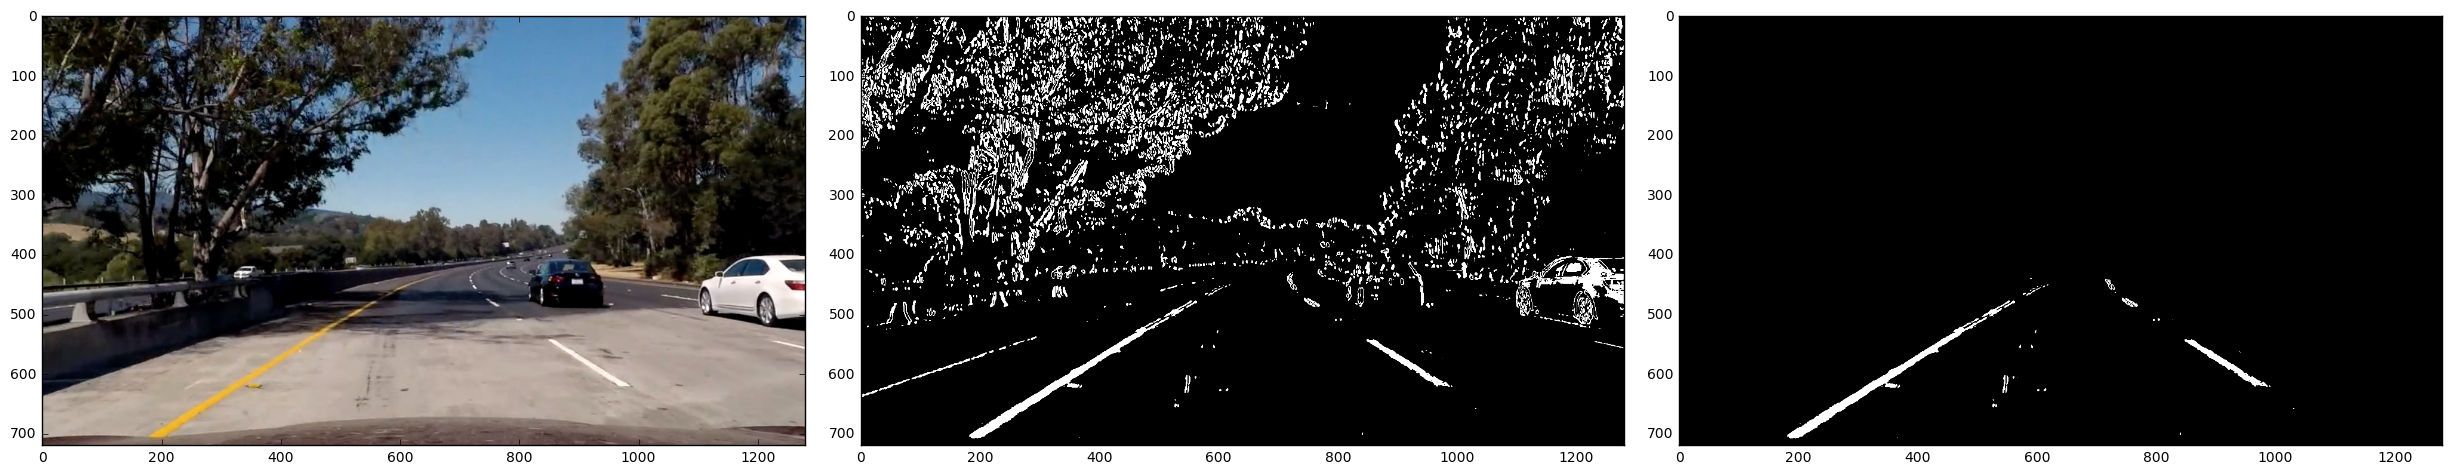

In [30]:
# Plot a test image for the following -
# 1) Undistorted image of a road
# 2) Binary Image after applying all the thresholds
# 3) Image of the road after applying region masking
img1 = mpimg.imread('./test_images/test5.jpg')
undist = undistort(img1, objpoints, imgpoints)
# Apply sobel filter
# Chose a larger odd number to smooth gradient measurements
gradx = abs_sobel_thresh(undist, orient='x', sobel_kernel=9, thresh=(30,100))
# S channel
s_channel = hls_select(undist, thresh = (120,255))
# V channel
v_channel = hsv_select(undist,thresh=(75,255))
combined_binary = np.zeros_like(gradx)
combined_binary[(gradx == 1)|(s_channel == 1)&(v_channel == 1)]=1
imshape = combined_binary.shape
vertices = np.array([[(100,imshape[0]),(620,420),(750,450),(1200,imshape[0])]],dtype=np.int32)
binary_output = region_of_interest(combined_binary,vertices)
#Plot Images
f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(24,9))
f.tight_layout()
ax1.imshow(undist)
ax2.imshow(combined_binary,cmap='gray')
ax3.imshow(binary_output,cmap='gray')
plt.subplots_adjust(left=0.,right=1,top=0.9,bottom=0.)

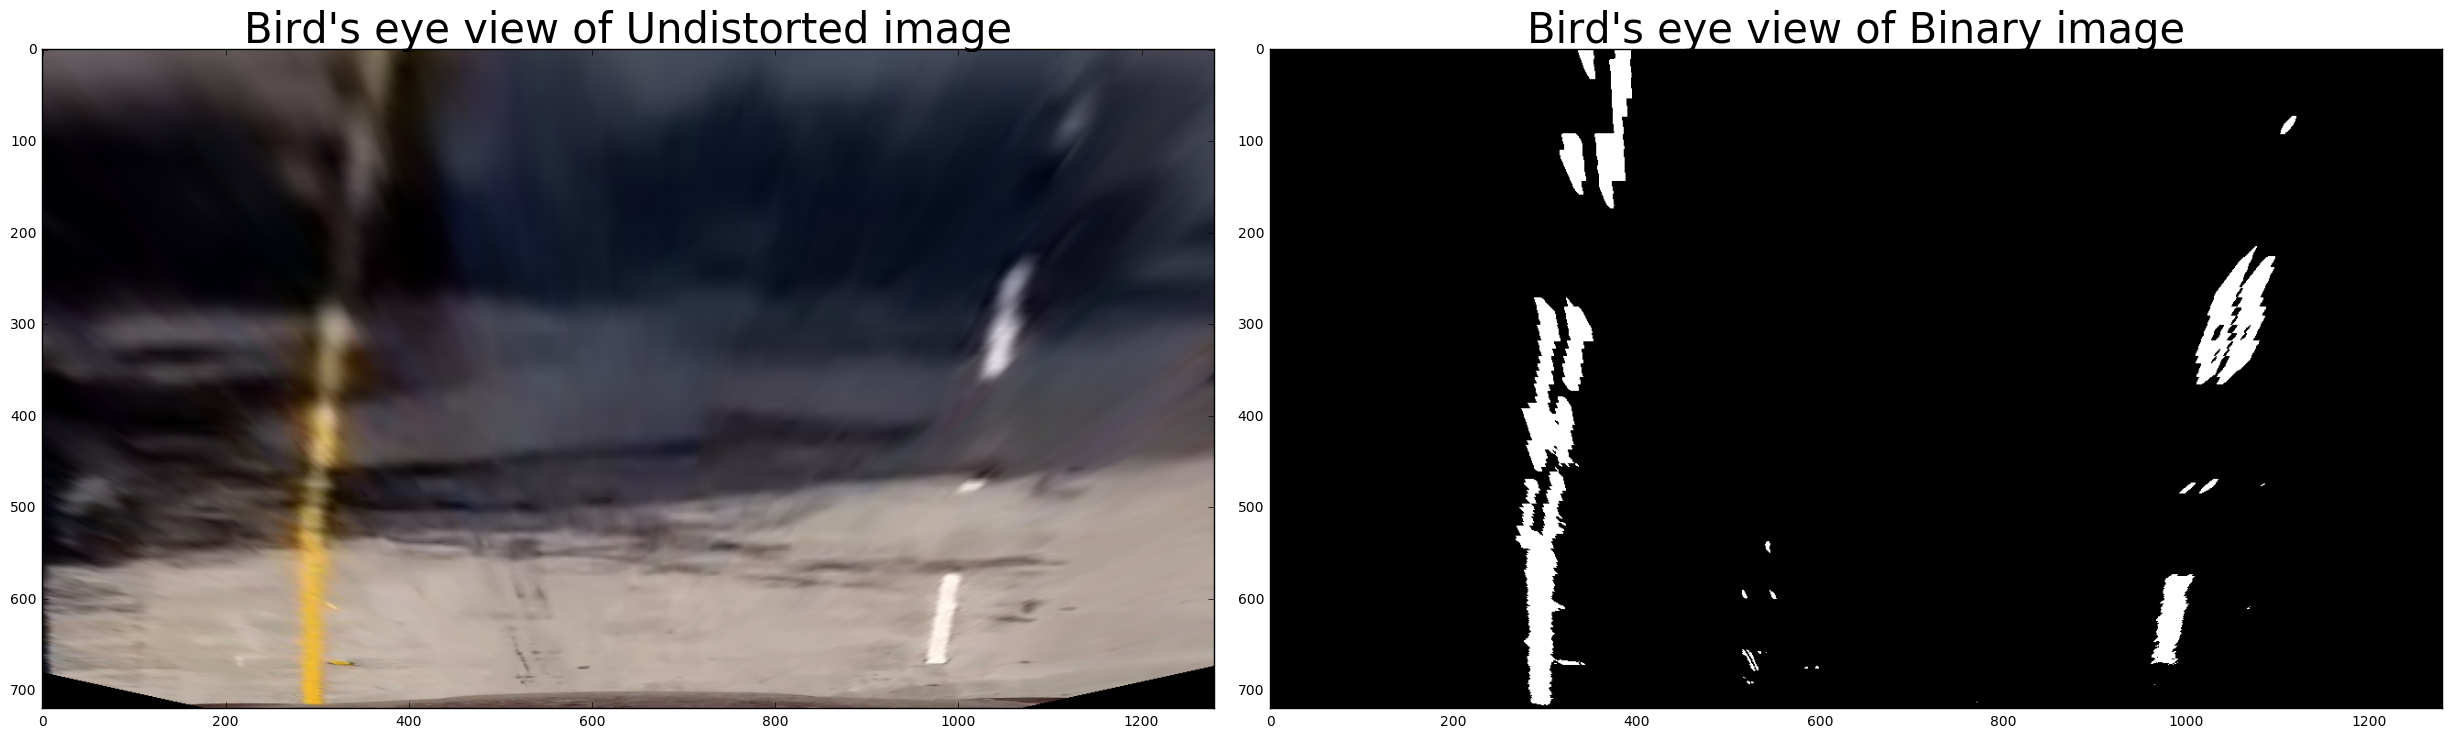

In [31]:
# Plot images after prespective transform of undistorted image and a binary image 
# Define source and destination points manually. Reference from Udacity lecture
src = np.float32([
    [585,460],
    [203,720],
    [1127,720],
    [695,460]])
dst = np.float32([
    [320,0],
    [320,720],
    [960,720],
    [960,0]])

#Compute the perspective transform, M, given source and destination points:
M = cv2.getPerspectiveTransform(src,dst)
# Warped image of the undistorted image (undist variable is set in the above cell)
undist_warped = cv2.warpPerspective(undist,M,(1280,720))
# Warped image of the binary image
binary_warped = cv2.warpPerspective(binary_output,M,(1280,720))
# Plot the images
f, (ax1,ax2) = plt.subplots(1,2,figsize=(24,9))
f.tight_layout()
ax1.imshow(undist_warped)
ax1.set_title("Bird's eye view of Undistorted image",fontsize=30)
ax2.imshow(binary_warped,cmap='gray')
ax2.set_title("Bird's eye view of Binary image",fontsize=30)
plt.subplots_adjust(left=0.,right=1,top=0.9,bottom=0.)

# Lane detection

I first computed the histogram of the picture on its lower half to find the rough position of each lane line (cell # 32). It is explained in detail in code comments

I then ran a sliding window vertically to detect the position of the center of each lane line on each part of the image (cell # 32). Logic explained in comments

I then used these positions to compute polylines describing each lane line using the np.polyfit() method  with degree=2.

In [32]:
# This is the actual pipleine where all the functions are called in appropriate sequence and lanes are mapped.
def process(image):

#The source and destination co-ordinates are referenced from Udacity's SDCND lectures.
    src = np.float32([
        [585,460],
        [203,720],
        [1127,720],
        [695,460]])
    dst = np.float32([
        [320,0],
        [320,720],
        [960,720],
        [960,0]])
    # Call the binary function to get the binary image 
    undist, combined_binary, binary_output = binary(image)
    
    # Perform warping on the binary image
    binary_warped = perspectiveTransform(binary_output,src,dst)
    #print(np.sum(binary_warped[binary_warped.shape[0]/2:,:],axis=0))
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    #print (nonzero)
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    
    # We now have a binary image where the lane lines stand out more or less clearly. However, we still need to 
    # figure explicitly which pixels are part of the lines and which belong to the left line and which belong to the
    # right line. Time to map out the lane lines
    
     
    global left_fit, right_fit, left_poly_list, right_poly_list
    # We want to see where the two lanes start. Only to be done for the first frame 
    if (left_fit, right_fit) == (None,None):

        # Take a histogram of the bottom half of the image
        # Two most prominent peaks in this histogram will be good indicators of the x-position 
        # of the base of the lane lines
        # We can use that as a starting point for where to search for the lines. 
        # From that point, we can use a sliding window, 
        # placed around the line centers, to find and follow the lines up to the top of the frame.
        
        histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:],axis=0)
        plt.plot(histogram)
        
      
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)

        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        #print (leftx_base)

        #sliding window
        nwindows = 9
        
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        
        # Set minimum number of pixels found to recenter window
        minpix = 50 
        
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        
        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            #print (win_y_low)
            win_y_high = binary_warped.shape[0] - (window*window_height)
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin 
            
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) 
                          & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) 
                          & (nonzerox < win_xright_high)).nonzero()[0]
            #print (good_left_inds,good_right_inds)
            #print (type(left_lane_inds))
            
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
            #print (left_lane_inds,right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty,leftx, 2)
        right_fit = np.polyfit(righty,rightx,2)
        left_poly_list = np.array([left_fit])
        right_poly_list = np.array([right_fit])
    else:
        
            #In the next frame of video we don't need to do a blind search again, 
            #but instead we can just search in a margin around the previous line position
            left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) &
                         (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
            right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) &
                         (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))
            
            # Again extract left and right line pixel positions
            leftx = nonzerox[left_lane_inds]
            lefty = nonzeroy[left_lane_inds]
            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds]
            
            #Fit 2nd polynomial
            left_fit = np.polyfit(lefty,leftx, 2)
            right_fit = np.polyfit(righty,rightx,2)
        
    #Average poly coefficient up to the last 5 frames
    left_poly_list = np.concatenate((left_poly_list,[left_fit]),axis=0)[-5:]
    right_poly_list = np.concatenate((right_poly_list,[right_fit]),axis=0)[-5:]
    left_fit = np.average(left_poly_list,axis=0)
    right_fit = np.average(right_poly_list,axis=0)
    
    #Generate x and y values for plotting
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img[lefty, leftx] = [255,0,0]
    out_img[righty,rightx] = [0,0,255]

    ploty = np.linspace(0, binary_warped.shape[0]-1,binary_warped.shape[0])
    
    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    left_poly = np.array([np.transpose(np.vstack([left_fitx,ploty]))])
    right_poly = np.array([np.flipud(np.transpose(np.vstack([right_fitx,ploty])))])
    lane_poly = np.hstack((left_poly,right_poly))
    
    # Create an image to draw the lines on
    window_img = np.zeros_like(out_img)
    
    cv2.polylines(window_img,np.int32(left_poly),1,(255,0,0),50)
    cv2.polylines(window_img,np.int32(right_poly),1,(255,0,0),50)
    
    # Draw the lane onto the warped blank image
    result = cv2.fillPoly(window_img,np.int_([lane_poly]),(0,255,0))

    # Warp the blank back to original image (This calls cv2.warpPerspective internally)
    unwarp = perspectiveTransform(result,dst,src)
    undist_copy = np.copy(undist)
    
    # Combine the result with the original image
    final = cv2.addWeighted(undist_copy,1,unwarp,0.5,0)
    
    # Call radius of Curvature and offcenter functions
    radius = measureCurvature(ploty,leftx,lefty,rightx,righty)
    off_center = offcenter(final,ploty,left_fit,right_fit)
    
    # Display the radius of curvature on the image
    cv2.putText(final,'Radius of Curvature: %.3f (m)' % radius,(20,40),cv2.FONT_HERSHEY_SIMPLEX,
                               1,(0,0,255),1,cv2.LINE_AA)
    # Display the off center value on the image
    cv2.putText(final,'Vehicle is %.3f (m) to the left of the center' % off_center,(20,80),cv2.FONT_HERSHEY_SIMPLEX,
                               1,(0,255,255),3,cv2.LINE_AA)
    return final

# Measuring lane curvature

I used the computed polyline along with the estimated lane width (~3.7m) to compute the real-world lane curvature. The function receives vectors for x and y coordinates of the fitted polynomial, converts them from pixel space to meter space by multiplying by a constant, fits polynomial again, this time in meter space and calculates curvature. I also measured the position of the car in respect to the lane by computing the difference between the center of the lane and the center of the image.

These computations can be found in the measureCurvature() and off_center() method in cell #13. 

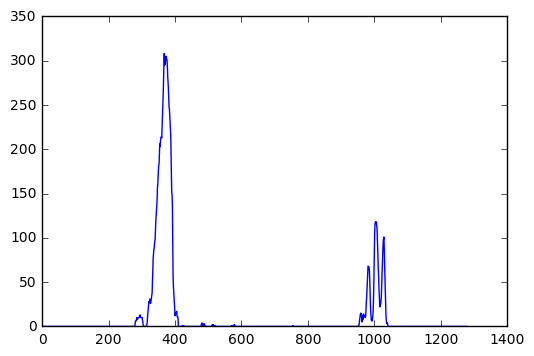

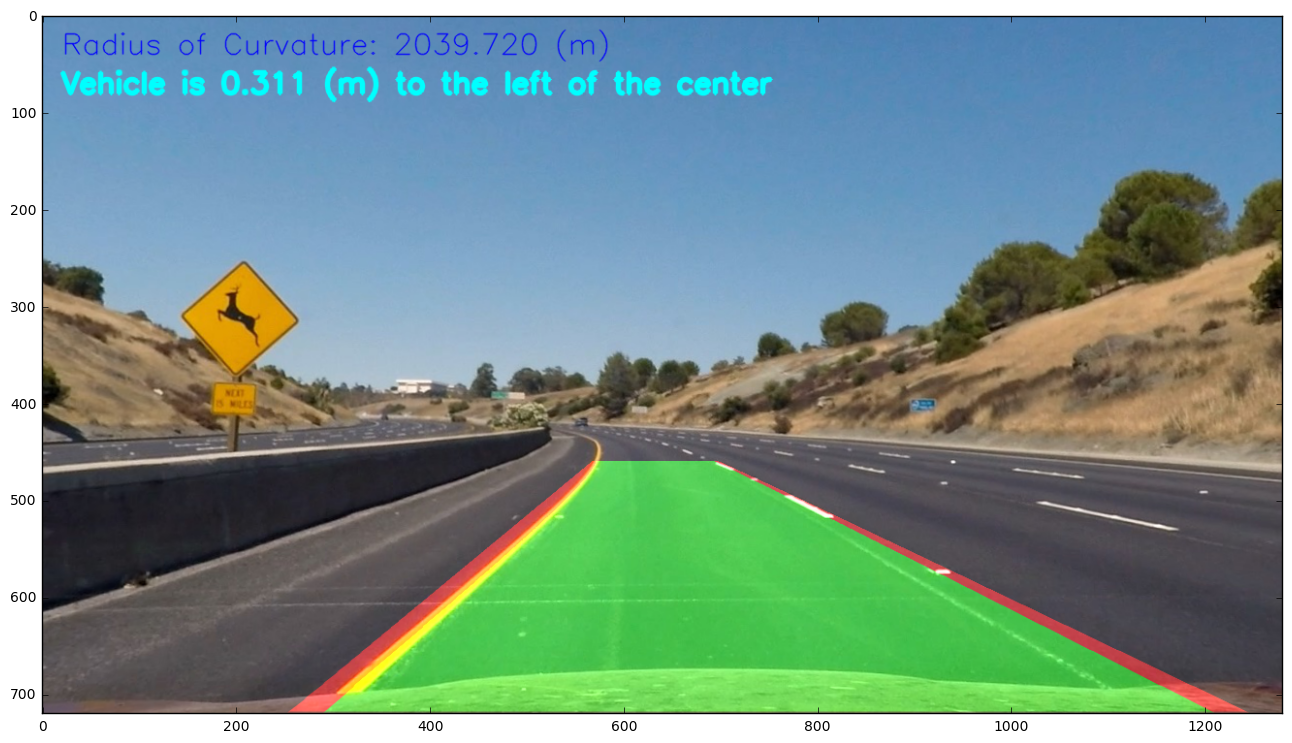

In [33]:
%matplotlib inline
img1 = mpimg.imread('./test_images/test2.jpg')
left_fit,right_fit = None,None
result = process(img1)
#Plot Images
plt.figure(figsize=(24,9))
plt.imshow(result)

In [20]:
# Apply the logic to the video
from moviepy.editor import VideoFileClip
from IPython.display import HTML
project_output = 'project_vid.mp4'
clip1 = VideoFileClip('project_video.mp4')
left_fit, right_fit = None, None
project_clip = clip1.fl_image(process)
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_vid.mp4
[MoviePy] Writing video project_vid.mp4


100%|█████████▉| 1260/1261 [22:54<00:00,  1.30it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_vid.mp4 

CPU times: user 28min 26s, sys: 1min, total: 29min 26s
Wall time: 22min 55s


# Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?

This was a very tedious project involving lot of experimentation with several parameters. 
Computer vision solutions are sensitive to the chosen parameters and if the parameters are not chosen correctly they don't work that great. In the beginning I struggled in developing a good intuition about what technique (for eg. I didn't have to use direction or magnitude of gradient) would work best for all the different test videos and the thresholding aspect (what value works better for yellow and white lines ). It got better after I went through scores of documentation aroung color spaces.

This approach would possibly fail where lanes line colors are different than white and yellow, or if they are worn out or missing. Need to do more experimentation with the thresholding techniques to make it work better for other videos.

I personally found deep learning to be inherently more robust if we have enough driving data (or augmented data) and also easier to code :)